# Classification on activations
We saw earlier that activations (from the last token, for some layers) from true and false statements were linearly separable. We will now train try and train a classifier on these activations to see if we can classify true and false statements.

We will start by using only the activations from the layers 10 or 18 which are the most easily separable ones and then we'll try to use the activations from all the layers to see if the classifier still manages to make correct predictions (which would enable a more general way to train it that could be extended to other models easily).

### Load data from 10th layer
We will start by loading the activations from the 10th layer and the labels for the true and false statements.

In [47]:
import pandas as pd


def load_nth_layer_data(nth):
    data_path = f'../data/activations/cities/layer_{nth}_output_cities.csv'
    data = pd.read_csv(data_path)
    return data

data = load_nth_layer_data(10)

print(f'Data contains {data.shape[1] - 1} activation values for {data.shape[0]} statements')
print('The last column contains the labels (1 for true, 0 for false)')

Data contains 5120 activation values for 1495 statements
The last column contains the labels (1 for true, 0 for false)


### Train a classifier
The first classifier we will use is a logistic regression that fits well the binary classification problem we have here.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def get_accuracy(data, clf, test_size=0.2, random_state=42, nb_samples=None):
    if nb_samples is None:
        nb_samples = data.shape[0]
    x = data.iloc[:nb_samples, :-1]
    y = data.iloc[:nb_samples, -1]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [37]:
from sklearn.linear_model import LogisticRegression


nth = 10
data = load_nth_layer_data(nth)

clf = LogisticRegression(max_iter=1000)
accuracy = get_accuracy(data, clf)
print(f'Accuracy of {clf.__class__.__name__} on layer {nth} activations: {accuracy:.2f}')

Accuracy of LogisticRegression on layer 10 activations: 1.00


We can also try to train a Random Forest classifier.

In [42]:
from sklearn.ensemble import RandomForestClassifier


nth = 10
data = load_nth_layer_data(nth)

clf = RandomForestClassifier()
accuracy = get_accuracy(data, clf)
print(f'Accuracy of {clf.__class__.__name__} on layer {nth} activations: {accuracy:.2f}')

Accuracy of RandomForestClassifier on layer 10 activations: 0.99


### Plotting accuracy

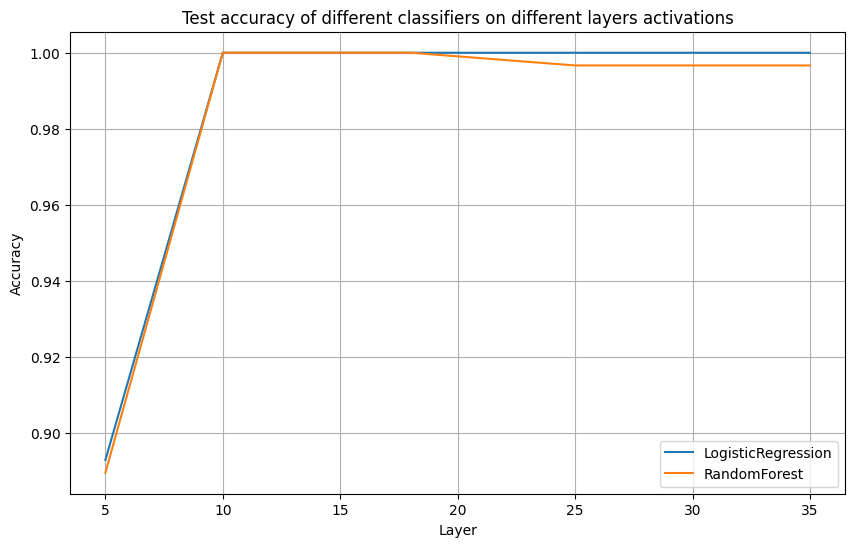

In [54]:
import matplotlib.pyplot as plt


def plot_accuracy(layers, clfs):
    accuracies = {clf.__class__.__name__: [] for clf in clfs}

    for nth in layers:
        data = load_nth_layer_data(nth)
        for clf in clfs:
            accuracy = get_accuracy(data, clf)
            accuracies[clf.__class__.__name__].append(accuracy)

    plt.figure(figsize=(10, 6))
    for clf, acc in accuracies.items():
        plt.plot(layers, acc, label=clf.replace('Classifier', ''))
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')
    plt.title('Test accuracy of different classifiers on different layers activations')
    plt.legend()
    plt.grid()
    plt.show()

layers = [5, 10, 18, 25, 35]
clfs = [LogisticRegression(max_iter=1000), RandomForestClassifier()]

plot_accuracy(layers, clfs)

### Merging activations from all layers
We will now try to merge the activations from all the layers and train a classifier on these.

In [53]:
def load_merged_data(layers=[5, 10, 18, 25, 35]):
    datas = [load_nth_layer_data(nth) for nth in layers]
    for i in range(len(datas) - 1):
        datas[i].drop(datas[i].columns[-1], axis=1, inplace=True)

    data = pd.concat(datas, axis=1)
    
    return data

layers = [5, 10, 18, 25, 35]
data = load_merged_data()
print(f'Data contains {data.shape[1] - 1} activation values from {len(layers)} layers for {data.shape[0]} statements')
print('The last column contains the labels (1 for true, 0 for false)')

Data contains 25600 activation values from 5 layers for 1495 statements
The last column contains the labels (1 for true, 0 for false)


In [55]:
data = load_merged_data()

acc = get_accuracy(data, RandomForestClassifier())
print(f'Accuracy of RandomForestClassifier on merged layers activations: {acc:.2f}')

acc = get_accuracy(data, LogisticRegression(max_iter=1000))
print(f'Accuracy of LogisticRegression on merged layers activations: {acc:.2f}')

Accuracy of RandomForestClassifier on merged layers activations: 1.00
Accuracy of LogisticRegression on merged layers activations: 1.00


### Locating the most important activation values
Now we know that the classifiers can make accurate predictions using the activations from all the layers, we can try to locate the most important activation values for the classifier.

We can use the feature importance from the Random Forest classifier to see which activations are the most important.

In [61]:
layers = [5, 10, 18, 25, 35]
data = load_merged_data(layers)
clf = RandomForestClassifier()

# Fit the model on the whole dataset
get_accuracy(data, clf)

importances = clf.feature_importances_
# Scale the importances between 0 and 1
importances = importances / importances.max()

print(f'Importances shape: {importances.shape}')
nb_activations_by_layer = (data.shape[1] - 1) // len(layers)
importances = importances.reshape(len(layers), nb_activations_by_layer)
print(f'Importances shape after reshaping: {importances.shape}')

Importances shape: (25600,)
Importances shape after reshaping: (5, 5120)


In [85]:
import numpy as np
import seaborn as sns
import math


def plot_heatmaps(importances, layers):
    original_shape = (128, 40)
    importances_reshaped = []
    for i in range(len(importances)):
        importances_reshaped.append(np.array(importances[i]).reshape(original_shape))
    
    ncols = 2
    nrows = math.ceil(len(importances) / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
    for i, ax in enumerate(axs.flat):
        if i < len(importances):
            ax = sns.heatmap(importances_reshaped[i], cmap='coolwarm', square=False, vmin=0, vmax=1, ax=ax)
            ax.set_title(f'Layer {layers[i]} Activation Importance Heatmap')
            ax.set_xlabel('Neuron x-coordinate')
            ax.set_ylabel('Neuron y-coordinate')
        else:
            fig.delaxes(ax)
    
    plt.tight_layout(pad=2.0)
    plt.show()

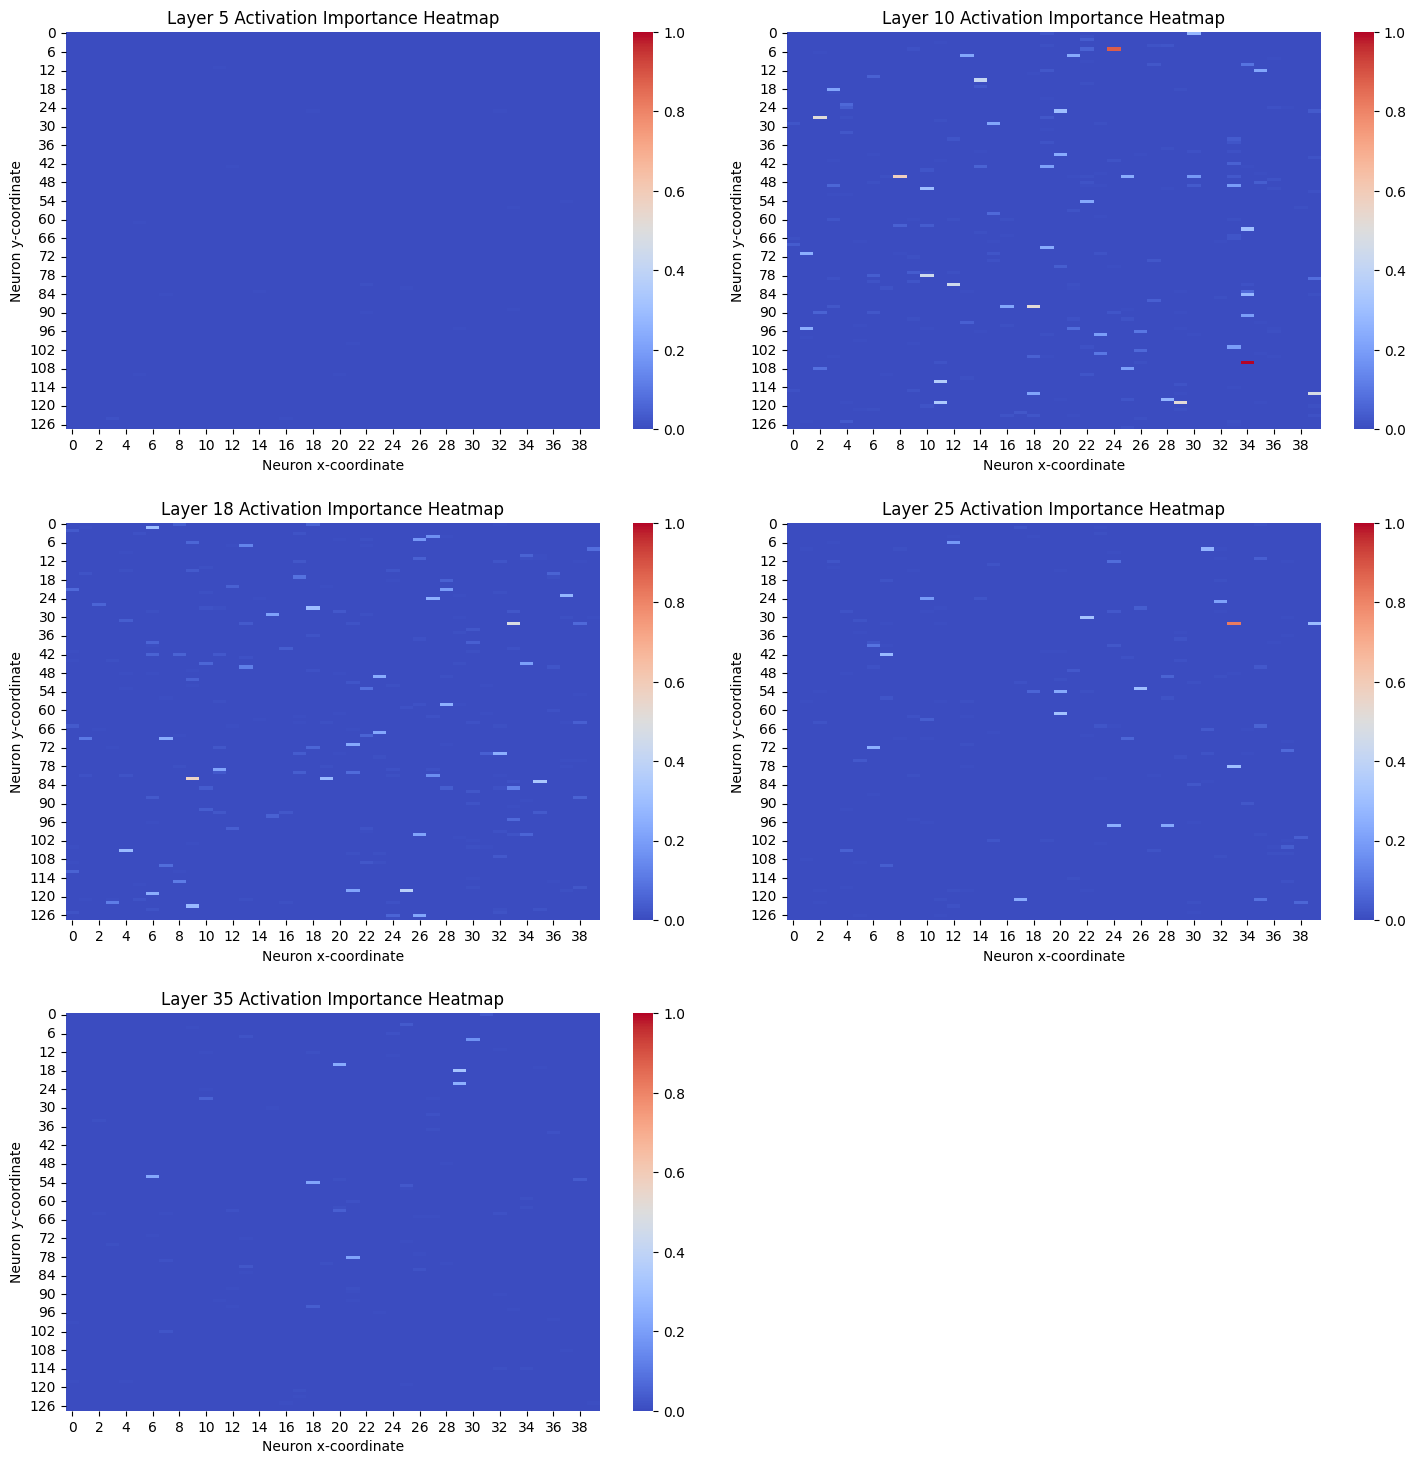

In [86]:
plot_heatmaps(importances, layers)